In [1]:
import pandas as pd
import numpy as np
import json
import collections
from gensim.models import Word2Vec
import itertools
import io
from datetime import datetime
import shlex, subprocess
import time
import glob
import csv
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.decomposition import PCA
import string

C:\Users\nroy0\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Read Files

In [2]:
docs = json.load(open("C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/document_passages.json"))
example_passage = docs['543']['42']

In [3]:
docs = json.load(open('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/document_passages.json'))
train = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/train.tsv', sep ='\t')

In [4]:
test = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/test.tsv', sep ='\t')
dev = pd.read_csv('C:/Users/nroy0/Downloads/Thesis/Lemur/WikiPassageQA/dev.tsv', sep ='\t')

In [6]:
stop = json.load(open('SMARTstop.json'))

In [118]:
test = test.reindex(range(0,414))

## Create Methods

In [7]:
# -*- coding: utf-8 -*-
import re
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "e.g." in text: text = text.replace("e.g.","e<prd>g<prd>")
    if "i.e." in text: text = text.replace("i.e.","i<prd>e<prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [8]:
def prepare_question_text(q_id, question_text):
    question_text = question_text.replace('?','') #remove ?
    question_text = question_text.replace("'",'')
    question_text = question_text.replace('"','')
    question_text = question_text.replace('-',' ')
    question_text = question_text.replace('(','')
    question_text = question_text.replace(')','')
    question_text = question_text.replace(',','')
    question_text = question_text.replace('.','')
    question_text = question_text.replace('&',' and ')
    question_text = question_text.replace(':','')
    question_text = question_text.replace('>','')#error in dataset

    if "[" in question_text:
        #print q_id,question_text
        if q_id == "3340": #remove contents
            question_text = re.sub(r'\[[^\(]*?\]', r'', question_text)
        else: #keep contents
            question_text = re.sub(r'\[(?:[^\]|]*\|)?([^\]|]*)\]', r'\1', question_text)
    if "/" in question_text:
        #print q_id,question_text
        if q_id == "104" or q_id == "857":
            question_text = question_text.replace('/','')
        else:
            question_text = question_text.replace('/',' or ')

    return question_text.lower()

In [9]:
def binaryEncoding(wordList, qText):
    questionList = qText
    binaryEncoded =np.array([ 1 if i in questionList else 0 for i in wordList])
    return binaryEncoded

In [10]:
def normalise(weights):
    sumW = np.sum(weights)
    normW = weights/sumW
    return normW

In [11]:
def candidateTerms(q_id, doc_id, question,k, alpha):
    #U = words.as_matrix()
    if alpha == 0.1:
        U = embedding1[doc_id]
    elif alpha ==0.01:
        U = embedding01[doc_id]
    else:
        U = embedding001[doc_id]
    wordList = words[doc_id]
    qText = prepare_question_text(q_id, question)
    filtered_text = removeStopWords(qText)
    q = binaryEncoding(wordList, filtered_text)
    # candidate = UU'q
    tmp = np.matmul(U.T,q)
    candidate = np.matmul(U,tmp)
    index = np.argsort(-candidate)[:k]
    weights = -np.sort(-candidate)[:k]
    normW = normalise(weights)
    expansionTerms = wordList[index]
    pqPlus = dict(zip(expansionTerms,normW))
    return pqPlus

In [12]:
def convertExpansionTerms(question_text, arr):
    onlyUniqueWords = [i for i in list(arr) if i.isalpha()]
#     onlyUniqueWords = np.setdiff1d(onlyWords, question_text.split())
    weightO = normalise([arr[x] for x in onlyUniqueWords])
    testStr = ""
    for item in range(len(onlyUniqueWords)):
        testStr = testStr + str(round(weightO[item],4))+" "+str(onlyUniqueWords[item]) + " "
    return testStr

In [13]:
def localExpansion(doc_id, dim, alpha):
    example_doc = docs[str(doc_id)]
    
    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    #lowercase
    textLower = [t.lower() for t in text]
    #tokenize
    tokens = [s.split() for s in textLower]
    #remove punctuation attached to words
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    
    #train word2vec
    model = Word2Vec(sentences, size = dim,  min_count = 1, alpha = alpha )
    model.train(sentences, total_examples = len(sentences), epochs = 150)
    
    #get wordList and embedding matrix U
    U = model.wv.vectors
    wordList = np.array(model.wv.index2word)
    return U, wordList

# Train word2vec on each document

Create a dictionary which stores the trained embedding matrix per document so that during query expansion, we just need to look up this embedding matrix for the respective query

In [14]:
embedding1 = {}
# embedding50 = {}
# # embedding001 = {}
# words50 = {}
words = {}
for doc_id in range(int(max(docs, key = int))+1):
# for doc_id in [355]:
    print(doc_id)
#     embedding50[doc_id], words50[doc_id]= localExpansion(doc_id, 50, 0.1)
    embedding1[doc_id], words[doc_id]= localExpansion(doc_id, 100, 0.1)
#     embedding001[doc_id], words[doc_id]= localExpansion(doc_id, 100, 0.001)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## More Methods

In [47]:
def removeStopWords(questionText):
    return [w for w in questionText.split()  if not w in stop]

In [48]:
def queryFormat(lamda, question_text, arr):
    expansionTerms = convertExpansionTerms(question_text, arr)
    filtered_text = removeStopWords(question_text)
    finalQueryText = '<text>#weight( ' + str(lamda)+' #combine ( '+ ' '.join(word for word in filtered_text) + " ) " + str(1 - lamda) + " #weight( " + expansionTerms + ") )</text>"
    return finalQueryText

In [14]:
def Local(expansion_terms, lamda, alpha):
    timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/local/query_local_'+str(lamda) + '_' + str(expansion_terms) +'_'+str(alpha)+'.txt'
    ftrain = io.open(queryFile, 'w+', encoding="utf-8")
    ftrain.write('<parameters>\n')
    for i in range(len(train)):
#         print(i)
        if(train['QID'][i] != 4148 or train['QID'][i] != 1315):
            ftrain.write('<query>\n')
            ftrain.write('<number>'+ str(train['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(train['QID'][i], train['Question'][i])
            arr = candidateTerms(train['QID'][i], train['DocumentID'][i], train['Question'][i], expansion_terms, alpha)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftrain.write(finalQueryText + '\n')
            docid = train['DocumentID'][i]
            for item in docs[str(train['DocumentID'][i])].keys():
                ftrain.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftrain.write('</query>\n')
    ftrain.write('</parameters>')
    ftrain.close()
    return queryFile

## Find best Parameter: No of expansion terms. lambda, mu. (alpha learning rate of word2vec was fixed at 0.1)

In [21]:
# for expansion_terms in [5, 50, 100, 200, 350, 500]:
for expansion_terms in [5, 50, 100, 200, 350]:
    for lamda in [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]:
        for alpha in [0.1]:
            startTime = time.time()
            queryFile = Local(expansion_terms, lamda,alpha)
            endTime = time.time()
            t_sec = round(endTime - startTime)
            (t_min, t_sec) = divmod(t_sec,60)
            print('Query File for Lamda {} and expansion terms {} and alpha {} created, time taken {} minutes and {} seconds'.format(lamda, expansion_terms,alpha, t_min, t_sec))
            for mu in [250, 500, 750, 1000, 1250]:
                startTime = time.time()
                outputFile = '3/QL_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'_'+str(alpha)+'].indri'
                command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
                args = shlex.split(command_input)
                p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
                endTime = time.time()
                t_sec = round(endTime - startTime)
                (t_min, t_sec) = divmod(t_sec,60)
                print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Query File for Lamda 0 and expansion terms 5 and alpha 0.1 created, time taken 0 minutes and 14 seconds
Mu 250 complete, time take 0 min and 6 sec
Mu 500 complete, time take 0 min and 6 sec
Mu 750 complete, time take 0 min and 6 sec
Mu 1000 complete, time take 0 min and 6 sec
Mu 1250 complete, time take 0 min and 6 sec
Query File for Lamda 0.15 and expansion terms 5 and alpha 0.1 created, time taken 0 minutes and 13 seconds
Mu 250 complete, time take 0 min and 6 sec
Mu 500 complete, time take 0 min and 6 sec
Mu 750 complete, time take 0 min and 6 sec
Mu 1000 complete, time take 0 min and 6 sec
Mu 1250 complete, time take 0 min and 6 sec
Query File for Lamda 0.3 and expansion terms 5 and alpha 0.1 created, time taken 0 minutes and 13 seconds
Mu 250 complete, time take 0 min and 6 sec
Mu 500 complete, time take 0 min and 6 sec
Mu 750 complete, time take 0 min and 6 sec
Mu 1000 complete, time take 0 min and 6 sec
Mu 1250 complete, time take 0 min and 6 sec
Query File for Lamda 0.45 and ex

Mu 250 complete, time take 1 min and 59 sec
Mu 500 complete, time take 1 min and 57 sec
Mu 750 complete, time take 1 min and 58 sec
Mu 1000 complete, time take 2 min and 2 sec
Mu 1250 complete, time take 1 min and 59 sec
Query File for Lamda 0.3 and expansion terms 200 and alpha 0.1 created, time taken 0 minutes and 20 seconds
Mu 250 complete, time take 2 min and 0 sec
Mu 500 complete, time take 2 min and 3 sec
Mu 750 complete, time take 2 min and 3 sec
Mu 1000 complete, time take 1 min and 52 sec
Mu 1250 complete, time take 2 min and 3 sec
Query File for Lamda 0.45 and expansion terms 200 and alpha 0.1 created, time taken 0 minutes and 21 seconds
Mu 250 complete, time take 2 min and 1 sec
Mu 500 complete, time take 2 min and 1 sec
Mu 750 complete, time take 2 min and 0 sec
Mu 1000 complete, time take 1 min and 51 sec
Mu 1250 complete, time take 1 min and 40 sec
Query File for Lamda 0.6 and expansion terms 200 and alpha 0.1 created, time taken 0 minutes and 19 seconds
Mu 250 complete, 

In [22]:

path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\3'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\_\d\.\d*]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQL = pd.concat(dfs, axis=1, ignore_index = False)

resultQL['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQL = resultQL.set_index('index')
resultQL

,QL_[1000_0.15_100_0.1],QL_[1000_0.15_200_0.1],QL_[1000_0.15_350_0.1],QL_[1000_0.15_50_0.1],QL_[1000_0.15_5_0.1],QL_[1000_0.3_100_0.1],QL_[1000_0.3_200_0.1],QL_[1000_0.3_350_0.1],QL_[1000_0.3_50_0.1],QL_[1000_0.3_5_0.1],...,QL_[750_0_100_0.1],QL_[750_0_200_0.1],QL_[750_0_350_0.1],QL_[750_0_50_0.1],QL_[750_0_5_0.1],QL_[750_1_100_0.1],QL_[750_1_200_0.1],QL_[750_1_350_0.1],QL_[750_1_50_0.1],QL_[750_1_5_0.1]
index,,,,,,,,,,,,,,,,,,,,,
num_q,3305.0000,3305.0000,3305.0000,3305.0000,3209.0000,3305.0000,3305.0000,3305.0000,3305.0000,3209.0000,...,3305.0000,3305.0000,3305.0000,3305.0000,3209.0000,3305.0000,3305.0000,3305.0000,3305.0000,3209.0000
num_ret,192376.0000,192376.0000,192376.0000,192376.0000,184972.0000,192376.0000,192376.0000,192376.0000,192376.0000,184972.0000,...,192376.0000,192376.0000,192376.0000,192376.0000,184972.0000,192376.0000,192376.0000,192376.0000,192376.0000,184972.0000
num_rel,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,...,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000
num_rel_ret,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,...,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000,5517.0000,5517.0000,5517.0000,5517.0000,5362.0000
map,0.4240,0.4480,0.4614,0.3942,0.2958,0.4839,0.4976,0.5040,0.4608,0.3435,...,0.3088,0.3064,0.2970,0.3082,0.2427,0.5153,0.5153,0.5153,0.5153,0.5137
gm_map,0.2661,0.2855,0.2953,0.2407,0.1657,0.3148,0.3253,0.3294,0.2948,0.1989,...,0.1731,0.1731,0.1660,0.1672,0.1165,0.3329,0.3329,0.3329,0.3329,0.3315
Rprec,0.3053,0.3290,0.3450,0.2707,0.1840,0.3733,0.3862,0.3948,0.3449,0.2292,...,0.1916,0.1871,0.1801,0.1977,0.1476,0.4174,0.4174,0.4174,0.4174,0.4156
bpref,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
recip_rank,0.4889,0.5156,0.5330,0.4521,0.3425,0.5624,0.5771,0.5853,0.5325,0.3975,...,0.3534,0.3530,0.3422,0.3507,0.2828,0.6034,0.6034,0.6034,0.6034,0.6006


In [23]:
resultQL.loc['ndcg_cut_10'].idxmax(axis=1)

'QL_[500_0.6_200_0.1]'

In [24]:
resultQL['QL_[500_0.6_200_0.1]']

index
num_q                      3305.0000
num_ret                  192376.0000
num_rel                    5517.0000
num_rel_ret                5517.0000
map                           0.5169
gm_map                        0.3391
Rprec                         0.4139
bpref                         1.0000
recip_rank                    0.6029
iprec_at_recall_0.00          0.6105
iprec_at_recall_0.10          0.6105
iprec_at_recall_0.20          0.6104
iprec_at_recall_0.30          0.6078
iprec_at_recall_0.40          0.5934
iprec_at_recall_0.50          0.5932
iprec_at_recall_0.60          0.4458
iprec_at_recall_0.70          0.4456
iprec_at_recall_0.80          0.4329
iprec_at_recall_0.90          0.4328
iprec_at_recall_1.00          0.4328
P_5                           0.1881
P_10                          0.1150
P_15                          0.0838
P_20                          0.0667
P_30                          0.0483
P_100                         0.0166
P_200                         0.

## Test set and metrics

In [79]:
def testLocal(expansion_terms, lamda, alpha):
    timeNow = datetime.now().strftime('%m%d%H%M')
    queryFile = 'C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/input/local/test_query_local_stoplow_'+str(lamda) + '_' + str(expansion_terms) +'_'+str(alpha)+'.txt'
    ftest = io.open(queryFile, 'w+', encoding="utf-8")
    ftest.write('<parameters>\n')
    for i in range(len(test)):
#         print(i)
        if( i != 259):
            ftest.write('<query>\n')
            ftest.write('<number>'+ str(test['QID'][i]) +'</number>\n')
            question_text = prepare_question_text(test['QID'][i], test['Question'][i])
            arr = candidateTerms(test['QID'][i], test['DocumentID'][i], test['Question'][i], expansion_terms, alpha)
            finalQueryText = queryFormat(lamda, question_text, arr)
            ftest.write(finalQueryText + '\n')
            docid = test['DocumentID'][i]
            for item in docs[str(test['DocumentID'][i])].keys():
                ftest.write('<workingSetDocno>'+str(docid)+'-'+str(item)+ '</workingSetDocno>\n')

            ftest.write('</query>\n')
    ftest.write('</parameters>')
    ftest.close()
    return queryFile

In [80]:
def testTrec(expansion_terms, lamda, alpha, mu):
    queryFile = testLocal(expansion_terms, lamda, alpha)
    startTime = time.time()
    outputFile = '3/Test/QL_stoplow_['+str(mu)+'_'+str(lamda)+'_'+str(expansion_terms)+'_'+str(alpha)+'].indri'
    command_input= r'"C:\Users\nroy0\Downloads\Thesis\Lemur\bin\IndriRunQuery.exe" '+str(queryFile)+' -index=C:/Users/nroy0/Downloads/Thesis/Lemur/dataset/index/WPQA_mod -count=1000 -trecFormat=true -queryOffset=-1 -rule=method:dirichlet,mu:' +str(mu)+' -stemmer.name=krovetz > C:/Users/nroy0/Downloads/Thesis/trec_eval.9.0/baseline/'+str(outputFile) 
    args = shlex.split(command_input)
    p = subprocess.run(args, stderr=subprocess.STDOUT,shell=True)
    endTime = time.time()
    t_sec = round(endTime - startTime)
    (t_min, t_sec) = divmod(t_sec,60)
    print("Mu {} complete, time take {} min and {} sec".format(mu, t_min, t_sec ))

In [81]:
testTrec(200, 0.6, 0.1,  500 )

C:\Users\nroy0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Mu 500 complete, time take 0 min and 16 sec


In [29]:
path = r'C:\Users\nroy0\Downloads\Thesis\trec_eval.9.0\baseline\3\Test'
filenames = glob.glob(path + "/*.csv")
dfs = []
count = 0
for filename in filenames:
    match = re.search(r'\w\w\_\[\d\.?\d*\_\d\.?\d*\_\d+\_\d\.\d*]', filename)
    count = count + 1
#     print(count)
    colname = match.group()
    df = pd.read_table(filename,sep='\t', index_col=None, header=None, usecols=[2], skiprows =1, names =  [colname] , quoting=csv.QUOTE_NONE)
    dfs.append(df)
resultQLTest = pd.concat(dfs, axis=1, ignore_index = False)

resultQLTest['index']=[ 'num_q',
'num_ret',
'num_rel',
'num_rel_ret',
'map',
'gm_map',
'Rprec',
'bpref',
'recip_rank',
'iprec_at_recall_0.00',
'iprec_at_recall_0.10',
'iprec_at_recall_0.20',
'iprec_at_recall_0.30',
'iprec_at_recall_0.40',
'iprec_at_recall_0.50',
'iprec_at_recall_0.60',
'iprec_at_recall_0.70',
'iprec_at_recall_0.80',
'iprec_at_recall_0.90',
'iprec_at_recall_1.00',
'P_5',
'P_10',
'P_15',
'P_20',
'P_30',
'P_100',
'P_200',
'P_500',
'P_1000',
'recall_5',
'recall_10',
'recall_15',
'recall_20',
'recall_30',
'recall_100',
'recall_200',
'recall_500',
'recall_1000',
'infAP',
'gm_bpref',
'Rprec_mult_0.20',
'Rprec_mult_0.40',
'Rprec_mult_0.60',
'Rprec_mult_0.80',
'Rprec_mult_1.00',
'Rprec_mult_1.20',
'Rprec_mult_1.40',
'Rprec_mult_1.60',
'Rprec_mult_1.80',
'Rprec_mult_2.00',
'utility',
'11pt_avg',
'binG',
'G',
'ndcg',
'ndcg_rel',
'Rndcg',
'ndcg_cut_5',
'ndcg_cut_10',
'ndcg_cut_15',
'ndcg_cut_20',
'ndcg_cut_30',
'ndcg_cut_100',
'ndcg_cut_200',
'ndcg_cut_500',
'ndcg_cut_1000',
'map_cut_5',
'map_cut_10',
'map_cut_15',
'map_cut_20',
'map_cut_30',
'map_cut_100',
'map_cut_200',
'map_cut_500',
'map_cut_1000',
'relative_P_5',
'relative_P_10',
'relative_P_15',
'relative_P_20',
'relative_P_30',
'relative_P_100',
'relative_P_200',
'relative_P_500',
'relative_P_1000',
'success_1',
'success_5',
'success_10',
'set_P',
'set_relative_P',
'set_recall',
'set_map',
'set_F',
'num_nonrel_judged_ret']
resultQLTest = resultQLTest.set_index('index')
resultQLTest

,QL_[500_0.6_200_0.1]
index,
num_q,411.0000
num_ret,23730.0000
num_rel,695.0000
num_rel_ret,695.0000
map,0.5273
gm_map,0.3382
Rprec,0.4297
bpref,1.0000
recip_rank,0.6135


In [30]:
resultQLTest.loc[['map', 'recip_rank','recall_10', 'P_10', 'ndcg', 'ndcg_cut_10']]

,QL_[500_0.6_200_0.1]
index,
map,0.5273
recip_rank,0.6135
recall_10,0.7267
P_10,0.1158
ndcg,0.6583
ndcg_cut_10,0.5893


## Experiments

In [20]:
question_text = prepare_question_text(train['QID'][3305], train['Question'][3305])
arr = candidateTerms(train['QID'][3305], train['DocumentID'][3305], train['Question'][3305], 15, 0.1)
finalQueryText = queryFormat(0.5, question_text, arr)
arr

{'Brunei,': 0.05344467464168905,
 'Kingdom': 0.057414168359245586,
 'Malaya': 0.07669570923526249,
 'Malaysian': 0.06255248062432624,
 'Singapore': 0.0737970075758554,
 'called': 0.0638467772212452,
 'country': 0.06016938481214156,
 'each': 0.056560805474376294,
 'economy': 0.10888186608209015,
 'federal': 0.052831618155536844,
 'federation': 0.05141887649134318,
 'independence': 0.09609737302723831,
 'it': 0.07418137949912577,
 'make': 0.049421172839408944,
 'name': 0.06268670596111496}

## Bubble Plot

In [400]:
def  popCan(docid, ct):
    example_doc = docs[str(docid)]

    doc = []
    for value in example_doc.values():
        doc.append(split_into_sentences(value))
    text = list(itertools.chain.from_iterable(doc))
    textLower = [t.lower() for t in text]
    tokens = [s.split() for s in textLower]
    table = str.maketrans('', '', string.punctuation)
    sentences = [[w.translate(table) for w in x if not w in stop] for x in tokens]
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
#     print(c)
    popct = [word for word, count in c.most_common() if word in ct]
    print(len(flat_list))
    popctE = getEmbed(popct, docid)
    return popctE

In [62]:
def getEmbed(a, docid):
    a1 = words[docid]
    a2 = [w for w in a if w in a1]
    idx = (a1[:, None] == a2).argmax(axis=0)
    X = embedding1[docid][idx]
    return X

In [347]:
def exEM(row):
    question_text = prepare_question_text(test['QID'][row], test['Question'][row]) ##291
    docid = test['DocumentID'][row]
    ct = candidateTerms(test['QID'][row],  test['DocumentID'][row], test['Question'][row], 300, 0.1).keys()
#     print((ct))
    a2Q= [word for word in [ w for w in question_text.split() if not w in stop] if word in words[docid]]
    popctE = popCan(docid, ct)
#     print(np.shape(popctE))
    a2QE = getEmbed(a2Q, docid)
    a2QE = np.mean(a2QE, axis =0 )
    X = np.vstack([a2QE, popctE])
    X_embedded = TSNE(n_components=2, verbose = 1, learning_rate=20, perplexity=50, n_iter=5000).fit_transform(X)
    return X_embedded

In [401]:
X_embedded = exEM(222)

3780
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.000s...
[t-SNE] Computed neighbors for 301 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 3.132210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.342472
[t-SNE] Error after 1700 iterations: 0.819389


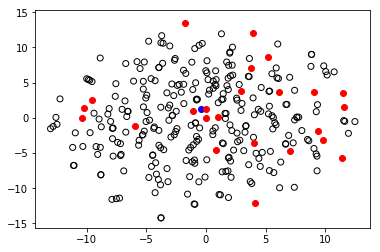

In [402]:
plt.scatter(X_embedded[0,0], X_embedded[0,1], color= 'blue')
# plt.scatter(np.mean(X_embedded[0:3], axis = 0)[0], np.mean(X_embedded[0:3], axis = 0)[1], color= 'blue')
plt.scatter(X_embedded[25:,0], X_embedded[25:,1],  facecolors='none', edgecolors='black')
plt.scatter(X_embedded[1:25,0], X_embedded[1:25,1], color = 'red')


## Question Analysis for which Local Embedding Model was poorer than Baseline

In [74]:
test.loc[test['QID']==  3185 ] ##1794

,QID,Question,DocumentID,DocumentName,RelevantPassages
29,3185,Explain about the term Deciduous,313,Deciduous.html,0


In [100]:
test[test.QID.isin([1059,1141,1572,2293,2345, 2360, 2746, 2821, 2851, 3445, 685])]

,QID,Question,DocumentID,DocumentName,RelevantPassages
35,2293,How did Dallas become a high-tech hub?,454,Dallas.html,"32,33"
43,2345,What motivated Alfred Thayer Mahan to start st...,136,Geopolitics.html,"1,2"
79,1572,What do national parks offer to people?,220,National_park.html,2
134,2360,How did Plato help instill the education process?,340,Education.html,2
148,2821,how would you describe molecular biology?,841,Biology.html,15
171,685,How did Stalin's death in 1953 affect the Sovi...,78,Soviet_Union.html,"2,3"
172,3445,How is the population of the Philippines distr...,729,Urban_area.html,"12,13"
206,1141,What are the external forcings of global warming?,376,Global_warming.html,8
273,1059,How did some states act against US government ...,84,Treaty_of_Paris_(1783).html,7
331,2746,What is Lyon's liveability rating?,459,Lyon.html,2


In [168]:
question_text = prepare_question_text(test['QID'][412], test['Question'][412])
print([word for word in [ w for w in question_text.split() if not w in stop] if word in words[393]])
print(question_text)

['history', 'eurasia']
what is the history of eurasia


In [165]:
arr = candidateTerms(test['QID'][412],  test['DocumentID'][134], test['Question'][134], 50, 0.1)
queryFormat(0.6, question_text, arr )

'<text>#weight( 0.6 #combine ( plato instill education process ) 0.4 #weight( 0.0374 process 0.0287 occurs 0.0269 informal 0.0248 time 0.0235 methods 0.0234 curriculum 0.0227 knowledge 0.0226 national 0.0225 variety 0.0222 philosophy 0.022 based 0.0219 higher 0.0216 skills 0.0215 young 0.021 aims 0.0206 place 0.0206 environment 0.0205 education 0.0201 children 0.0199 ongoing 0.0198 high 0.0197 developed 0.0195 intelligence 0.0194 sense 0.0192 own 0.0189 places 0.0186 formal 0.0185 arts 0.0184 modalities 0.0183 forms 0.0183 courses 0.0182 compulsory 0.0182 policy 0.0179 by 0.0175 physical 0.0174 takes 0.0174 college 0.0174 century 0.0172 indigenous 0.0171 twelve 0.0171 general 0.017 educated 0.017 absorbing 0.017 organizational 0.017 distance 0.0169 proportion 0.0168 resources 0.0167 acquisition 0.0167 values 0.0166 tertiary ) )</text>'

In [169]:
docs['393']['1']

'Some major islands, including Great Britain, Iceland, and Ireland, and those of Japan, the Philippines and Indonesia, are included under the popular definition of Eurasia, in spite of being separate from the massive landmass. Physiographically, Eurasia is a single continent. The concepts of Europe and Asia as distinct continents date back to antiquity and their borders are geologically arbitrary, with the Ural and Caucasus ranges being the main delimiters between the two. Eurasia is connected to Africa at the Suez Canal, and Eurasia is sometimes combined with Africa as the supercontinent Afro-Eurasia. Due to the vast landmass and differences in latitude, Eurasia exhibits all types of climate under the Koppen classification - including the harshest types of hot and cold temperatures, high and low precipitation and various types of ecosystems. Eurasia has been the host of many ancient civilizations, including those based in Mesopotamia, the Indus Valley and China.'

In [170]:
docs['393']['6']

'There is undeniably an influence of Panslavism in this definition; originally the idea of "Eurasia" was more romantically rooted in natural geography. It was the idea that the people scattered across the land called "Eurasia" shared common spiritual values due to its geographic traits, such as a flat land with few coastlines but important rivers, a particular climate , and a certain landscape . This idea was more or less realised, but with difficulty, during the last phases of the Russian Empire and was then realised again with the Soviet Union after 1945, though not stably enough for enduring success. Today, though this Russian geopolitical interest still exists, the physical area of the Russian "Eurasia" is now more realistically assessed. The Russian view today is that "Eurasia" consists of the land lying between Europe and Asia proper; namely, those made up of Western and Central Russia, Belarus, Ukraine, part of Caucasus, Uzbekistan, Kazakhstan, Tajikistan, and Kyrgyzstan . Just 

In [37]:
loserDF = test[test.QID.isin(errorList)]
len([q for q in loserDF.Question if q.lower().startswith('where')]) ##What - 41, How - 35 # Why - 8 #In -2 #Which -1

,QID,Question,DocumentID,DocumentName,RelevantPassages
6,1201,What happened in Poland in the era of insurrec...,474,Poland.html,"16,17"
10,3675,Why was Spain allowed into the UN?,527,Spain.html,34
11,104,How Does The Jain's Path Relate To The Practic...,260,Jainism.html,3
15,3981,How did Great Britain get it's name?,770,Great_Britain.html,"6,7"
16,78,What conservation issues face South Africa?,373,South_Africa.html,"35,36"
20,3039,how vastly dense and diverse is the city of sa...,573,So_Paulo.html,25
21,256,What proof is there that humans existed during...,243,Brazil.html,"4,5"
28,1871,How did Cleveland get its name?,158,Cleveland.html,1
32,332,What were the effects of politics on the 1972 ...,382,Summer_Olympic_Games.html,"18,19,20"
35,2293,How did Dallas become a high-tech hub?,454,Dallas.html,"32,33"
